# Scattering covariance synthesis

In this notebook, we intend to do simple tests with scattering covariance synthesis:
* Gaussian field (ex: CMB) + synthesis with only P00 => Gaussian field and same Power Spectrum (PS)
* Non Gaussian field (ex: Venus) + synthesis with only P00 => Gaussian field and same PS
* Gaussian field + synthesis with all coeffs => Gaussian field and same PS
* Non Gaussian field + synthesis with all coeffs => Non Gaussian field and same PS


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload

import foscat.Synthesis as synthe
import foscat.scat_cov as sc
import almscat.Sphere_lib as sphlib

2023-02-14 20:19:33.600387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 20:19:33.737954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 20:19:33.737981: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 20:19:34.464143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Get data

In [2]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 32  # NSIDE

Mean and STD: 0.000 and 1.000


<Figure size 1000x600 with 0 Axes>

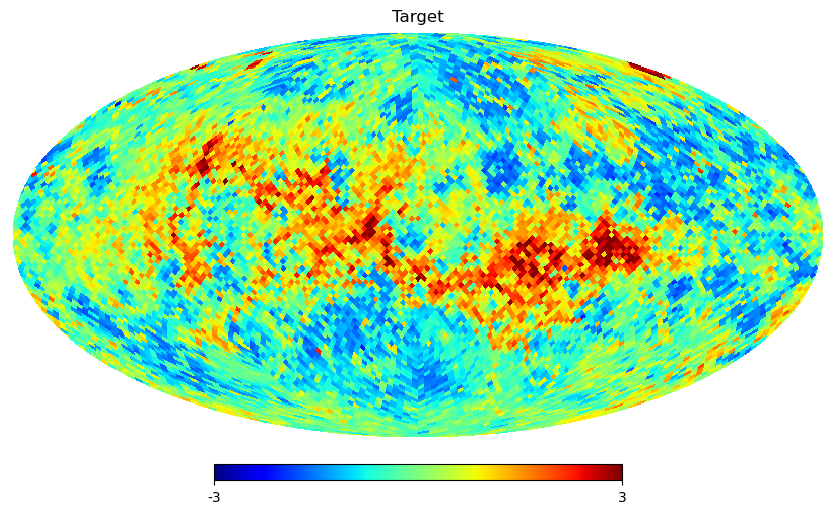

In [132]:
##### TARGET MAP: Choose between a Gaussian or a non Gaussian field
# tmap = sphlib.make_hpx_sky(nside=nout, sky_type='cmb', normalize=True, nest=True)  # CMB
tmap = sphlib.make_hpx_planet(nside=nout, planet='venus', interp=True, normalize=True, nest=True)  # Venus

# Plot the healpix map
plt.figure(figsize=(10, 6))
hp.mollview(tmap, cmap='jet', nest=True, title='Target', min=-3, max=3)

# INITIALIZE FoCUS class

In [159]:
reload(sc)
scat_op = sc.funct(NORIENT=3,   # define the number of wavelet orientation
                   KERNELSZ=5,  # define the kernel size (here 5x5)
                   OSTEP=-1,     # get very large scale (nside=1)
                   LAMBDA=1.,
                   TEMPLATE_PATH=scratch_path,
                   slope=1.,
                   use_R_format=True,
                   all_type='float32')


          START FOSCAT CONFIGURATION
Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==


# Initialize the loss

In [160]:
# Write the loss function
def lossP00(x, scat_op, args):

    tP00 = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xP00 = scat_op.eval(x, image2=None, norm=norm).P00

    loss = scat_op.reduce_sum(scat_op.square(xP00 - tP00))

    return loss

def lossAll(x, scat_op, args):

    tcoeff = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xcoeff = scat_op.eval(x, image2=None, norm=norm)

    loss = scat_op.reduce_sum(scat_op.square(xcoeff - tcoeff))
    return loss

In [161]:
# Choose the normalisation
norm = 'auto'

# Compute the auto coeffs of the target image
scat_op.clean_norm()
tcoeff = scat_op.eval(tmap, image2=None, norm=norm)
tP00 = tcoeff.P00

# Choose the loss
loss = synthe.Loss(lossAll, scat_op, tcoeff, norm)
# loss = synthe.Loss(lossP00, scat_op, tP00, norm)

# Build the synthesis class
sy = synthe.Synthesis([loss])

# Run the synthesis

In [162]:
### Initial condition MAP (white gaussian noise)
imap = np.random.randn(12*nout*nout)

In [163]:
### Run the synthesis
omap = sy.run(imap,
              DECAY_RATE=0.9998,
              NUM_EPOCHS = 1500,
              LEARNING_RATE = 0.03,
              EPSILON = 1E-16)

Total number of loss  1
Run on GPU CPU:0


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 0 L=626 (626 ) 24.409s 


/home/lmousset/lib/FOSCAT/src/foscat/Synthesis.py:160: UserWarning: loadtxt: input contained no data: "smi_tmp.txt"
  return np.loadtxt('smi_tmp.txt')
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 100 L=17.3 (17.3 ) 11.848s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 200 L=5.7 (5.7 ) 13.225s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 300 L=3.23 (3.23 ) 13.994s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 400 L=2.34 (2.34 ) 13.694s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 500 L=1.9 (1.9 ) 13.504s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 600 L=1.63 (1.63 ) 14.075s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 700 L=1.44 (1.44 ) 13.812s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 800 L=1.31 (1.31 ) 14.022s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 900 L=1.2 (1.2 ) 14.244s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 1000 L=1.12 (1.12 ) 13.772s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 1100 L=1.05 (1.05 ) 13.737s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 1200 L=0.991 (0.991 ) 13.775s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 1300 L=0.941 (0.941 ) 14.225s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


Itt 1400 L=0.896 (0.896 ) 13.832s 


sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found
sh: 1: nvidia-smi: not found


# Check the synthesis

In [164]:
# Compute the coeff
scat_op.clean_norm()
icoeff = scat_op.eval(imap, image2=None, norm=norm)

scat_op.clean_norm()
ocoeff = scat_op.eval(omap, image2=None, norm=norm)

tP00 = tcoeff.P00.numpy().squeeze()
iP00 = icoeff.P00.numpy().squeeze()
oP00 = ocoeff.P00.numpy().squeeze()

### Plot the maps

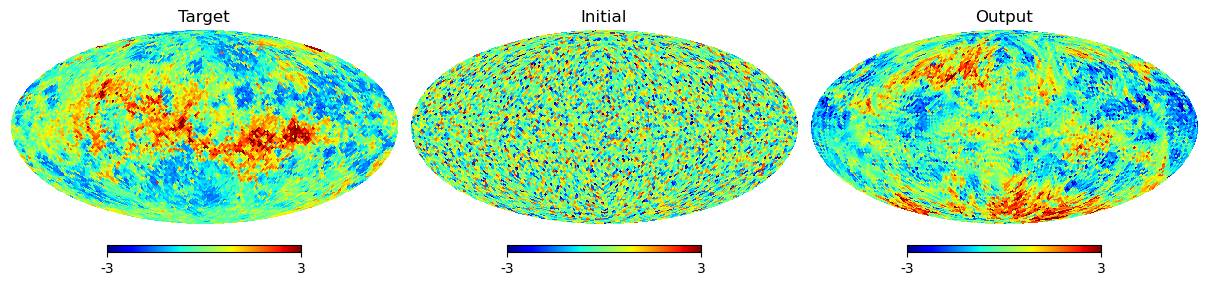

In [165]:
plt.figure(figsize=(12, 4))
hp.mollview(tmap, cmap='jet', hold=False, sub=(1, 3, 1), nest=True, title='Target', min=-3, max=3)
hp.mollview(imap, cmap='jet', hold=False, sub=(1, 3, 2), nest=True, title='Initial', min=-3, max=3)
hp.mollview(omap.numpy(), cmap='jet', hold=False, sub=(1, 3, 3), nest=True, title='Output', min=-3, max=3)

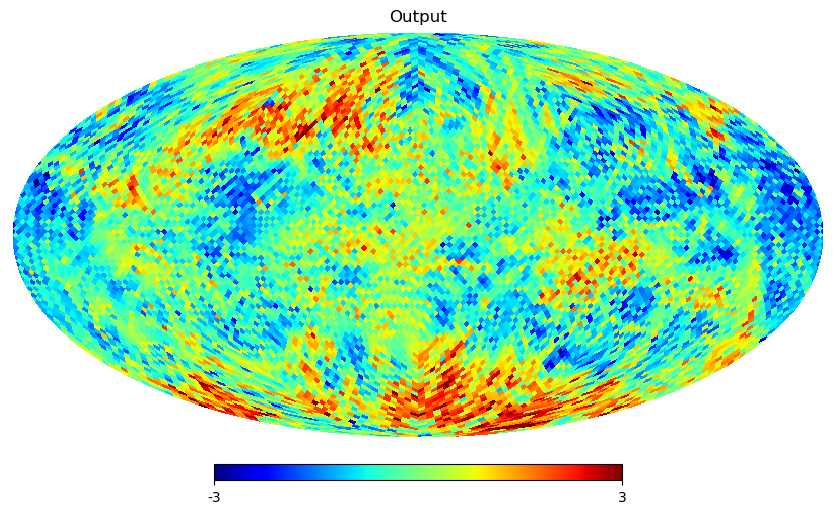

In [166]:
hp.mollview(omap.numpy(), cmap='jet', hold=False, nest=True, title='Output', min=-3, max=3)

### Plot all coeffs

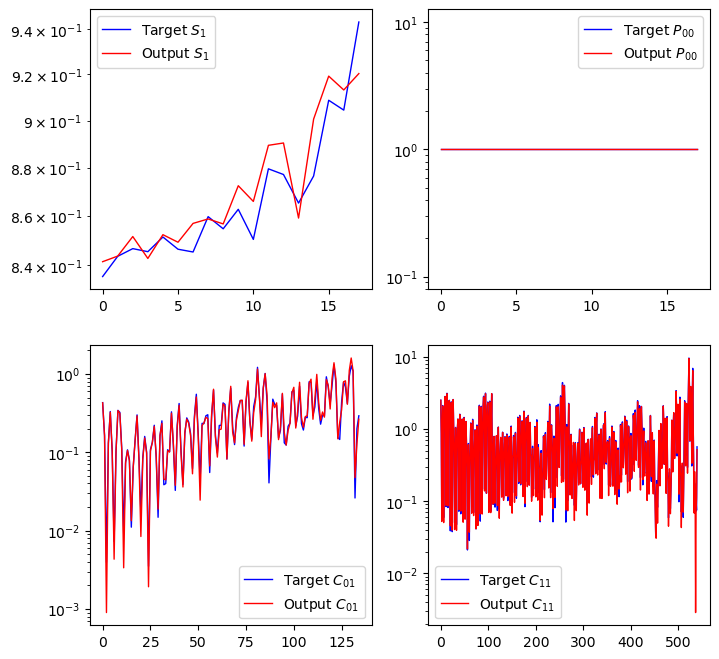

In [167]:
tcoeff.plot(color='b', name='Target')
# icoeff.plot(hold=False, color='g', name='Initial')
ocoeff.plot(hold=False, color='r', name='Output')


### Plot P00

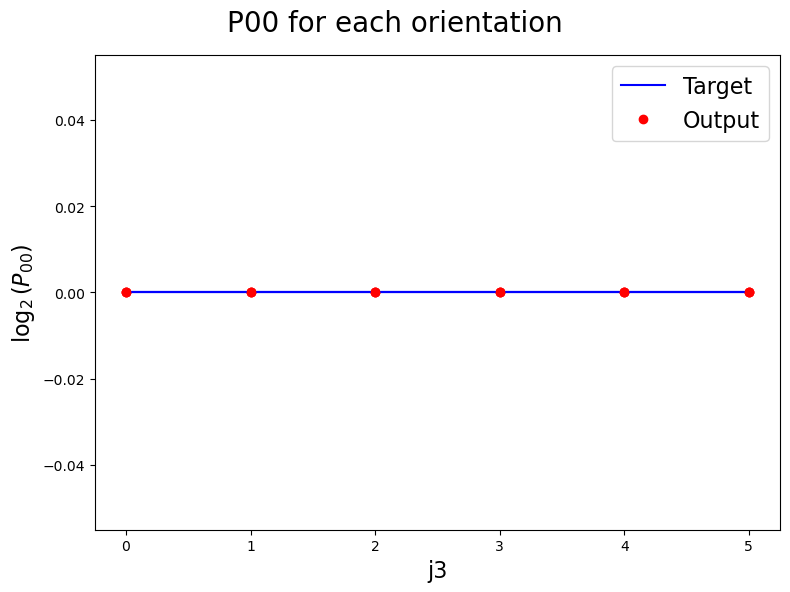

In [168]:
fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('P00 for each orientation',  fontsize=20)

for i in range(scat_op.NORIENT):
    ax0.plot(np.log2(tP00[:, i]), color='blue',label='Target')
    # ax0.plot(np.log2(gP00[:, i]), color='g',label='Initial')
    ax0.plot(np.log2(oP00[:, i]), 'o', color='red',label='Output')
    if i == 0:
        ax0.legend(fontsize=16)
ax0.set_xlabel('j3', fontsize=16)
ax0.set_ylabel(r'$\log_2(P_{00})$', fontsize=16)

fig.tight_layout()

### Angular power spectrum

Text(0, 0.5, '$C_\\ell$')

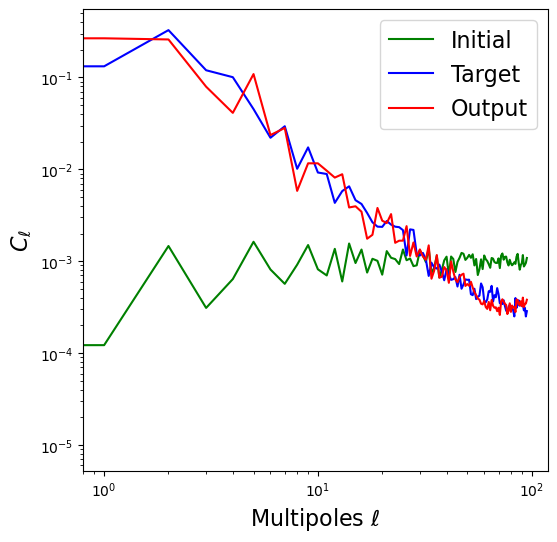

In [169]:
idx = hp.ring2nest(nout, np.arange(12*nout**2))

cli = hp.anafast((imap - np.median(imap))[idx])
clt = hp.anafast((tmap - np.median(tmap))[idx])
clo = hp.anafast((omap.numpy() - np.median(omap.numpy()))[idx])

plt.figure(figsize=(6,6))
plt.plot(cli,color='green',label=r'Initial')
plt.plot(clt,color='blue',label=r'Target')
plt.plot(clo,color='red',label=r'Output')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xlabel(r'Multipoles $\ell$', fontsize=16)
plt.ylabel(r'$C_\ell$', fontsize=16)

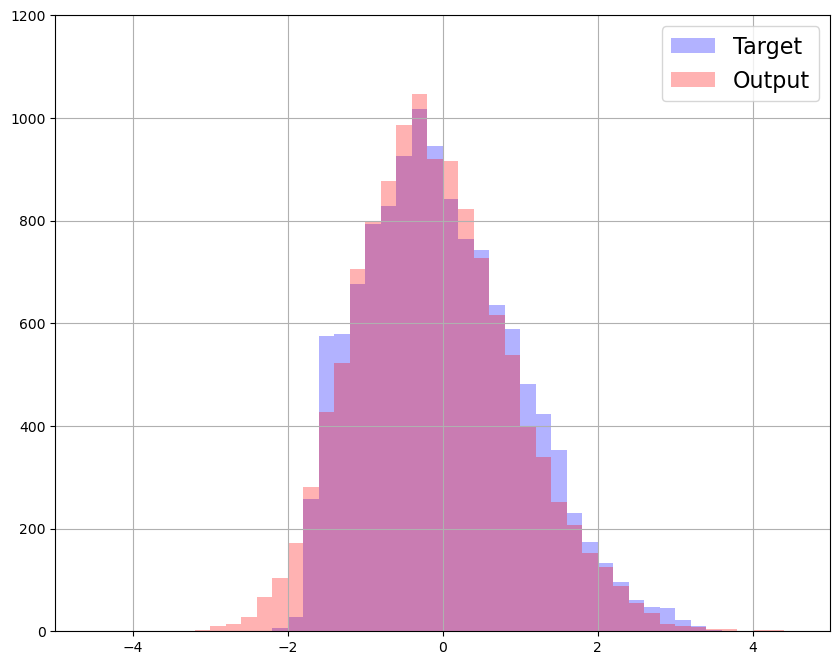

In [170]:
def plot_histo(target_hpx, synthetic_hpx, bins=50, range=(-5, 5), ymax=5000, fontsize=16):
    plt.figure(figsize=(10, 8))
    plt.hist(target_hpx.ravel(), bins=bins, range=range, color='b', alpha=0.3, label='Target')
    plt.hist(synthetic_hpx.ravel(), bins=bins, range=range, color='r', alpha=0.3, label='Output')
    plt.legend(fontsize=fontsize)
    plt.ylim(0, ymax)
    plt.xlim(range)
    plt.grid()
    return

plot_histo(tmap, omap.numpy(), ymax=1200)

(1500,)


Text(0.5, 0, 'Number of iterations')

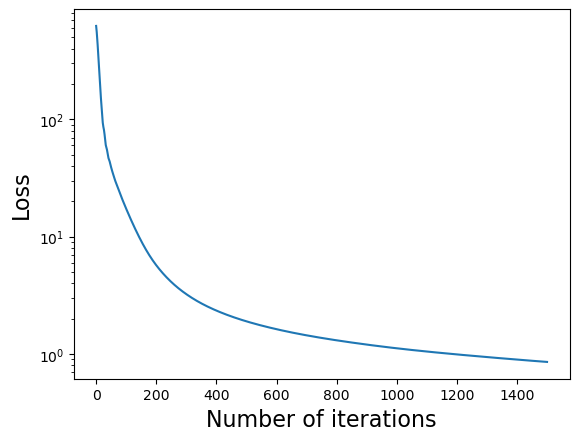

In [171]:
loss = sy.get_history()
print(loss.shape)


# Plot the loss
plt.figure()
plt.plot(loss[:])
plt.yscale('log')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)